In [1]:
from ml_mlp import MLP_Model
from ml_mlp import Linear_Model
from ml_mlp import MLP_Win_Model
import resources
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import multiprocessing
multiprocessing.set_start_method("spawn")

In [2]:
%matplotlib inline

# Pre-process data 
Load in feature datasets, remove wear in phase and combine.

In [3]:
exp5 = resources.load('Test 5')
exp7 = resources.load('Test 7')
exp8 = resources.load('Test 8')
exp9 = resources.load('Test 9')

In [4]:
dfs = [exp5.features.drop([23, 24]), exp7.features, exp8.features, exp9.features]
main_df = pd.concat(dfs)
main_df = main_df.drop(columns=['Runout', 'Form error', 'Peak radius', 'Radius diff'])#.drop([0, 1, 2, 3])
main_df.reset_index(drop=True, inplace=True)

In [5]:
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 708 rows x 8 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Mean radius
0,0.159501,12.643285,3.698928,-0.020471,40.801628,54.444047,19.697298,0.675643
1,1.330936,11.609588,15.609034,0.002392,44.433276,69.836889,38.384749,0.674763
2,1.999714,8.351972,19.288375,-0.039252,46.662722,74.074813,42.546872,0.674161
3,2.010478,8.404136,19.780447,-0.035595,46.317147,74.917782,42.614029,0.673917
4,2.114221,7.972116,22.575564,-0.037290,46.668332,75.681806,42.884298,0.673830


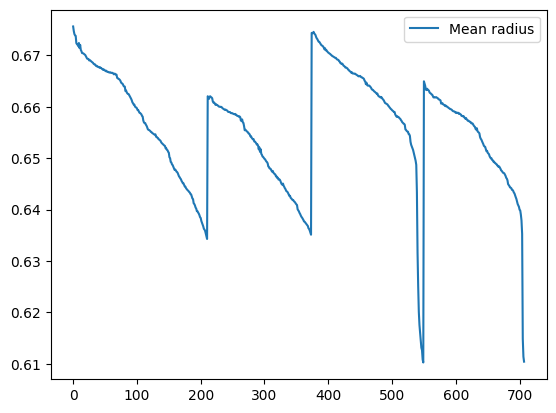

In [6]:
main_df.plot(y='Mean radius');

# Create Models

- MLP
- Linear
- MLP with window

In [7]:
mlp_reg = MLP_Model(feature_df=main_df,
                    target='Mean radius',
                    tb=True,
                    tb_logdir='tmux-test',
                    params={'loss': 'mse',
                            'no_layers': 4,
                            'no_nodes': 128,
                            'epochs': 1000,
                                }
                   )

In [8]:
lin_reg = Linear_Model(feature_df=main_df, target='Mean radius')

In [9]:
mlp_win_reg = MLP_Win_Model(feature_df=main_df,
                            target='Mean radius',
                            tb=True,
                            tb_logdir='tmux-test',
                            params={'seq_len': 5,
                                    'loss': 'mse',
                                    'epochs': 1000,
                                    'no_nodes': 128,
                                    'no_layers': 4,
                                    },
                            )

# Score models
## MLP:

CV Model:   0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------------
CV Training Scores:
-----------------------------------------------------------------
MAE: 1.313 (± 0.465) µm
MSE: 9.395 (± 10.177) µm²
R^2: 0.928 (± 0.077)
-----------------------------------------------------------------


Training:   0%|                                           0/1000 ETA: ?s,  ?epochs/s

-----------------------------------------------------------------
Model Validation Scores:
-----------------------------------------------------------------
MAE = 0.934 um
MSE = 2.080 um^2
R^2 = 0.977
-----------------------------------------------------------------


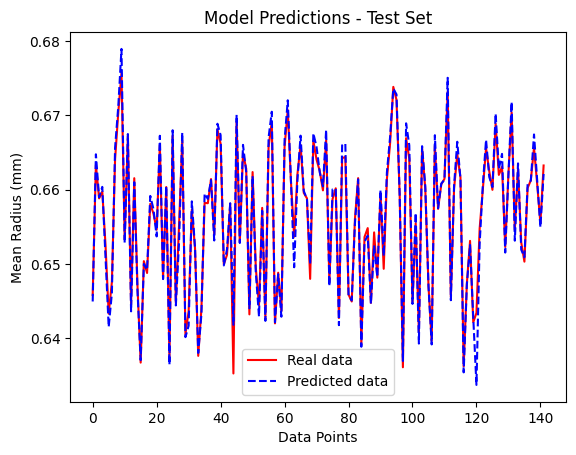

In [10]:
mlp_reg.cv(n_splits=10, n_repeats=10, random_state=15)
mlp_reg.fit(validation_split=0.1, verbose=0)
mlp_reg.score(plot_fig=True);


## MLP with window:

CV Model:   0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------------
CV Training Scores:
-----------------------------------------------------------------
MAE: 1.479 (± 0.653) µm
MSE: 17.873 (± 21.292) µm²
R^2: 0.834 (± 0.185)
-----------------------------------------------------------------


Training:   0%|                                           0/1000 ETA: ?s,  ?epochs/s

-----------------------------------------------------------------
Model Validation Scores:
-----------------------------------------------------------------
MAE = 1.997 um
MSE = 46.029 um^2
R^2 = 0.683
-----------------------------------------------------------------


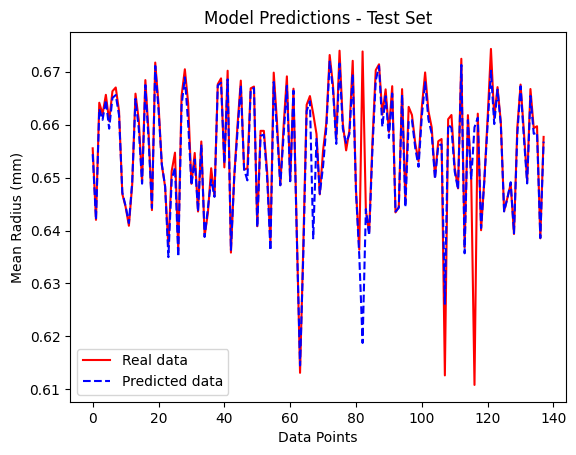

In [11]:
mlp_win_reg.cv(n_splits=10, n_repeats=10)
mlp_win_reg.fit(validation_split=0.2, verbose=0)
mlp_win_reg.score(plot_fig=True);

## Linear:

In [12]:
lin_reg.fit()
lin_reg.score(plot_fig=False);

-----------------------------------------------------------------
Model Validation Scores:
-----------------------------------------------------------------
MAE = 5.089 um
MSE = 48.416 um^2
R^2 = 0.526
-----------------------------------------------------------------


# Visualise predictions
## MLP:

In [13]:
def pred_plot(y: np.ndarray, y_pred: np.ndarray, title:str = ''):
    fig, ax = plt.subplots(1, 2)
    ax[0].scatter(y, y_pred)

    # limits of max radius
    xmax = main_df['Mean radius'].values.max()
    xmin = main_df['Mean radius'].values.min()

    ax[0].set_xlim([xmin, xmax])
    ax[0].set_ylim([xmin, xmax])

    lims = [
        np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
        np.max([ax[0].get_xlim(), ax[0].get_ylim()]),
    ]

    ax[0].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax[0].set_aspect('equal')
    ax[0].set_xlabel('Actual Y / mm')
    ax[0].set_ylabel('Predicted Y /mm')
    ax[0].set_title(f'{title} - Predictions');
    
    diff = (y - y_pred)*1000

    ax[1].hist(diff, bins=30)
    ax[1].set_xlabel('Prediction Error / um')
    ax[1].set_ylabel('No Occurances')
    ax[1].set_title(f'{title} - Histogram');

    fig.tight_layout()


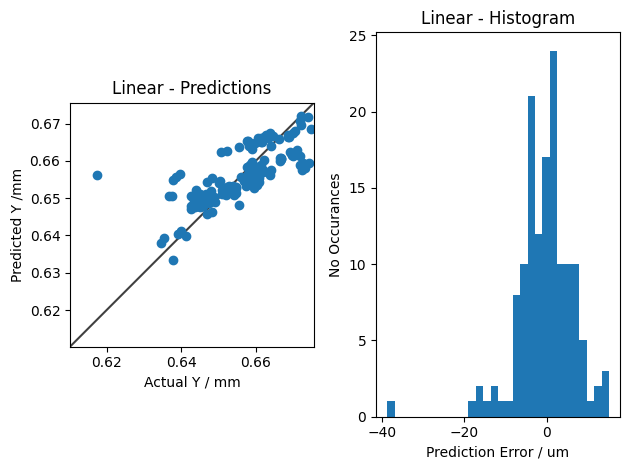

In [14]:
y = lin_reg.val_data[1].values
y_pred = lin_reg.model.predict(lin_reg.val_data[0].values)
pred_plot(y, y_pred, 'Linear')

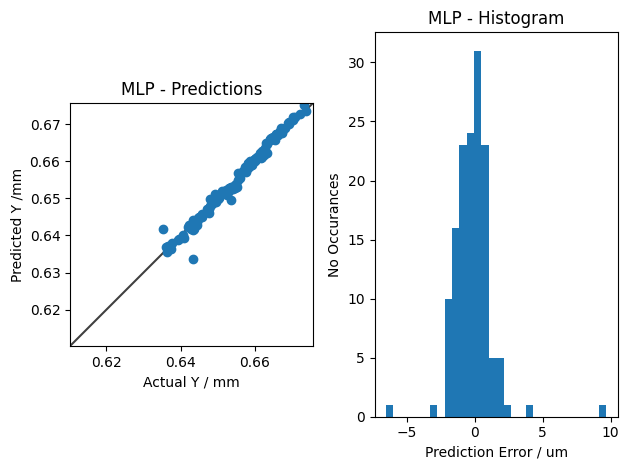

In [15]:
y = mlp_reg.val_data[1].values
y_pred = mlp_reg.model.predict(mlp_reg.val_data[0].values, verbose=0)
pred_plot(y, y_pred, 'MLP')

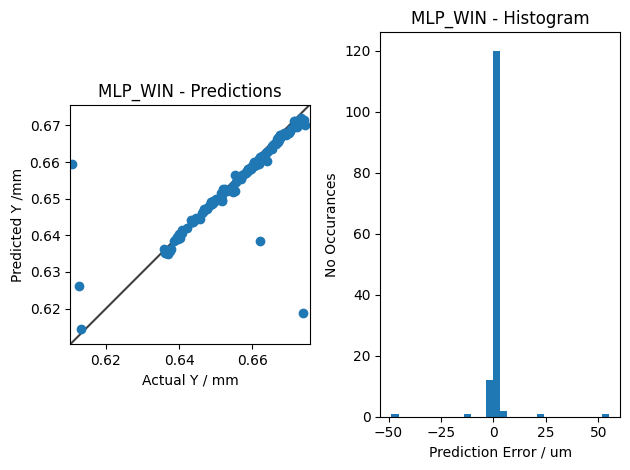

In [16]:
y = mlp_win_reg.val_data[1]
y_pred = mlp_win_reg.model.predict(mlp_win_reg.val_data[0], verbose=0)
pred_plot(y, y_pred, 'MLP_WIN')